In [1]:
import torch
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
from einops import rearrange
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import requests
import functions

from diffusers import DDIMScheduler, AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer



/Users/bglickenhaus/opt/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generation parameters
torch_device = "cpu"

scale = 3
h = 512
w = 512
ddim_eta = 0.0
num_inference_steps = 100
torch.manual_seed(0)
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
prompt = "A photo of Barack Obama smiling with a big grin"
input_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/440px-Official_portrait_of_Barack_Obama.jpg?20090114181817"
input_image = Image.open(requests.get(input_image_url, stream=True).raw).convert("RGB")


In [4]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae");

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14");
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14");

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet");
scheduler = DDIMScheduler()
scheduler.set_timesteps(num_inference_steps)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.5.mlp.fc2.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.18.self_attn.v_proj.bias', 'vision_model.encoder.layers.19.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.15

In [5]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [6]:
x = to_tensor(input_image).unsqueeze(0).to(torch_device)
enc = vae.encode(x)
init_latent = enc.latent_dist.sample()
decoded_image = vae.decode(init_latent)

In [7]:
# decoded_image = vae.decode(latents)


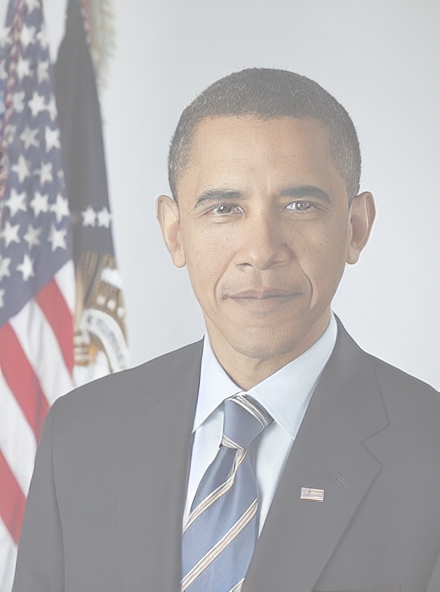

In [8]:
# latents = 1 / 0.18215 * init_latent
image = (decoded_image.sample / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

display(pil_images[0])

In [9]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    original_text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
text_embeddings = original_text_embeddings.clone()

In [16]:
text_embeddings = functions.optimize_text_embeddings(
    text_embeddings,
    init_latent,
    unet,
    scheduler,
    torch_device=torch_device,
)


[1.2312791347503662, 0.1900642216205597, 0.008517922833561897]

In [19]:
functions.finetune(text_embeddings, init_latent, unet, scheduler, torch_device=torch_device)


tensor(0.4867, grad_fn=<MseLossBackward0>)

In [ ]:
latents = functions.interpolate(
    original_text_embeddings,
    text_embeddings,
    unet,
    scheduler,
)


In [ ]:
new_img = vae.decode(latents).sample

In [ ]:
image = (new_img / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

display(pil_images[0])